In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
import matplotlib.pyplot as plt
from torchinfo import summary
from datetime import datetime

In [2]:
# 데이터 경로 설정
data_path = os.path.join(os.getcwd(), "_00_data", "fashion_mnist")

# Wandb 초기화
wandb.init(project="fashion-mnist-homework", config={"batch_size": 256, "learning_rate": 0.001, "epochs": 100})
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alstjr7141 (alstjr7141-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


In [3]:
# 문제 1
# 평균(mean)과 표준편차(std)를 계산하는 함수
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))  # 전체 데이터를 로드
    data = next(iter(loader))[0]  # 첫 번째 배치에서 데이터 추출
    mean = data.mean().item()  # 평균 계산
    std = data.std().item()  # 표준편차 계산
    return mean, std

# Fashion MNIST 데이터 로드 및 평균, 표준편차 계산
transform = transforms.ToTensor()  # 텐서 변환
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)  # 학습 데이터 로드
f_mnist_mean, f_mnist_std = calculate_mean_std(f_mnist_train)  # 평균, 표준편차 계산
print(f"Calculated Mean: {f_mnist_mean}, Std: {f_mnist_std}")  # 결과 출력

# 데이터 변환 설정 (정규화 및 데이터 증강 추가)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 랜덤 가로 뒤집기
    transforms.RandomRotation(10),  # 랜덤 회전 (10도 이내)
    transforms.ToTensor(),  # 텐서 변환
    transforms.Normalize(mean=f_mnist_mean, std=f_mnist_std),  # 정규화
])

# 데이터셋 분할
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=False, transform=transform)  # 학습 데이터 로드
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])  # 학습/검증 데이터 분할
f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),  # 텐서 변환
    transforms.Normalize(mean=f_mnist_mean, std=f_mnist_std),  # 정규화
]))

# DataLoader 생성
train_loader = DataLoader(f_mnist_train, batch_size=config.batch_size, shuffle=True)  # 학습 데이터 로더
validation_loader = DataLoader(f_mnist_validation, batch_size=config.batch_size)  # 검증 데이터 로더
test_loader = DataLoader(f_mnist_test, batch_size=config.batch_size)  # 테스트 데이터 로더

Calculated Mean: 0.28604060411453247, Std: 0.3530242443084717


In [4]:
# 문제 2
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1채널 -> 32채널
            nn.ReLU(),  # 활성화 함수
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.MaxPool2d(kernel_size=2, stride=2),  # 풀링
            nn.Dropout(0.2),  # 드롭아웃

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 32채널 -> 64채널
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=1),  # NiN 구조
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 풀링
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64채널 -> 128채널
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=1),  # NiN 구조
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 풀링
            nn.Dropout(0.4),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # 평탄화
            nn.Linear(128 * 3 * 3, 256),  # 완전연결층
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 10)  # 출력층 (10 클래스)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # 합성곱 계층
        x = self.fc_layers(x)  # 완전연결 계층
        return x

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 또는 CPU 선택
print(f"Using device: {device}")  # 사용 중인 장치 출력

# 모델, 손실함수, 옵티마이저 초기화
model = CNN().to(device)  # 모델을 장치로 이동
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)  # 옵티마이저
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)  # 학습률 스케줄러

print(summary(model, input_size=(config.batch_size, 1, 28, 28)))  # 모델 요약 출력

# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=15, verbose=False, path='best_model.pth'):
        self.patience = 15  # 최대 기다림 횟수
        self.verbose = verbose  # 디버그 메시지 표시 여부
        self.counter = 0  # 카운터
        self.best_loss = None  # 최적 손실값
        self.early_stop = False  # 조기 종료 여부
        self.path = path  # 모델 저장 경로
        self.best_model = None  # 최적 모델
        self.max_accuracy = 94.0  # 조기 종료 정확도 임계값

    def __call__(self, val_loss, model, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # 손실 감소 확인
            self.best_loss = val_loss  # 최적 손실값 갱신
            self.counter = 0  # 카운터 리셋
            torch.save(model.state_dict(), self.path)  # 모델 저장
            if self.verbose:
                print(f"Validation Loss Improved, Saving Model: {val_loss:.4f}")
        else:
            self.counter += 1  # 카운터 증가
            if self.verbose:
                print(f"EarlyStopping Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:  # 조기 종료 조건 충족
                self.early_stop = True

        if val_accuracy >= self.max_accuracy:  # 정확도가 임계값 이상일 경우
            self.early_stop = True
            if self.verbose:
                print(f"Early stopping triggered due to val_accuracy >= {self.max_accuracy}%")


# EarlyStopping 초기화
early_stopping = EarlyStopping(patience=15)

# 학습 및 검증 루프
def train_model(model, train_loader, validation_loader, criterion, optimizer, device, num_epochs, patience=5, model_path='best_model.pth'):
    model.to(device)  # 모델 장치 이동
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=model_path)  # EarlyStopping 초기화

    for epoch in range(num_epochs):  # 에포크 반복
        model.train()  # 학습 모드
        running_loss = 0.0  # 학습 손실 초기화
        correct = 0  # 정답 카운터 초기화
        total = 0  # 전체 카운터 초기화
        for images, labels in train_loader:  # 배치 반복
            images, labels = images.to(device), labels.to(device)  # 데이터 장치로 이동
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(images)  # 모델 출력
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 갱신

            running_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측값 계산
            total += labels.size(0)  # 전체 개수 증가
            correct += (predicted == labels).sum().item()  # 정답 개수 증가

        train_accuracy = 100 * correct / total  # 학습 정확도 계산
        train_loss = running_loss / len(train_loader)  # 학습 손실 평균 계산

        # 검증 단계
        val_accuracy, val_loss = validate_model(model, validation_loader, criterion, device)  # 검증 실행
        wandb.log({  # Wandb 로깅
            "epoch": epoch + 1,
            "Train loss": train_loss,
            "Train accuracy": train_accuracy,
            "Validation loss": val_loss,
            "Validation Accuracy": val_accuracy
        })

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # 조기 종료 체크
        early_stopping(val_loss, model, val_accuracy)  # EarlyStopping 호출, val_accuracy 추가 전달
        if early_stopping.early_stop:  # 조기 종료 조건 확인
            print("Early stopping triggered")
            break

    model.load_state_dict(torch.load(model_path))  # 최적 모델 로드
    print("Loaded Best Model from", model_path)


# 검증 함수 정의
def validate_model(model, validation_loader, criterion, device):
    model.eval()  # 평가 모드
    running_loss = 0.0  # 손실 초기화
    correct = 0  # 정답 개수 초기화
    total = 0  # 전체 개수 초기화
    with torch.no_grad():  # 그래디언트 비활성화
        for images, labels in validation_loader:  # 배치 반복
            images, labels = images.to(device), labels.to(device)  # 데이터 장치로 이동
            outputs = model(images)  # 모델 출력
            loss = criterion(outputs, labels)  # 손실 계산
            running_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs, 1)  # 예측값 계산
            total += labels.size(0)  # 전체 개수 증가
            correct += (predicted == labels).sum().item()  # 정답 개수 증가

    accuracy = 100 * correct / total  # 정확도 계산
    avg_loss = running_loss / len(validation_loader)  # 평균 손실 계산
    return accuracy, avg_loss  # 결과 반환



Using device: cuda
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 128, 3, 3]          --
│    └─Conv2d: 2-1                       [256, 32, 28, 28]         320
│    └─ReLU: 2-2                         [256, 32, 28, 28]         --
│    └─BatchNorm2d: 2-3                  [256, 32, 28, 28]         64
│    └─MaxPool2d: 2-4                    [256, 32, 14, 14]         --
│    └─Dropout: 2-5                      [256, 32, 14, 14]         --
│    └─Conv2d: 2-6                       [256, 64, 14, 14]         18,496
│    └─ReLU: 2-7                         [256, 64, 14, 14]         --
│    └─BatchNorm2d: 2-8                  [256, 64, 14, 14]         128
│    └─Conv2d: 2-9                       [256, 64, 14, 14]         4,160
│    └─ReLU: 2-10                        [256, 64, 14, 14]         --
│    └─BatchNorm2d: 2-11                 [256, 64, 14, 14

In [5]:
# 문제 3
# 테스트 함수 정의
def test_model(model, test_loader, device):
    model.eval()  # 평가 모드
    correct = 0  # 정답 개수 초기화
    total = 0  # 전체 개수 초기화
    with torch.no_grad():  # 그래디언트 비활성화
        for images, labels in test_loader:  # 배치 반복
            images, labels = images.to(device), labels.to(device)  # 데이터 장치로 이동
            outputs = model(images)  # 모델 출력
            _, predicted = torch.max(outputs, 1)  # 예측값 계산
            total += labels.size(0)  # 전체 개수 증가
            correct += (predicted == labels).sum().item()  # 정답 개수 증가

    accuracy = 100 * correct / total  # 정확도 계산
    print(f"Test Accuracy: {accuracy:.4f}")  # 결과 출력
    wandb.log({"Test Accuracy": accuracy})  # Wandb 로깅

In [6]:
# 문제 4
# 테스트 데이터 예측 및 시각화 함수 정의
def visualize_predictions(model, test_loader, device):
    model.eval()  # 평가 모드로 설정
    samples = []  # 시각화할 샘플 리스트
    with torch.no_grad():  # 그래디언트 비활성화
        for images, labels in test_loader:  # 테스트 데이터 반복
            images, labels = images.to(device), labels.to(device)  # 데이터를 장치로 이동
            outputs = model(images)  # 모델 출력
            preds = outputs.argmax(1)  # 예측값 계산
            for i in range(10):  # 처음 10개의 샘플 수집
                samples.append((images[i], labels[i].item(), preds[i].item()))  # 이미지, 라벨, 예측값 저장
                if len(samples) == 10:  # 10개가 모이면 중지
                    break
            if len(samples) == 10:  # 외부 루프 중지 조건
                break

    # 시각화
    fig, axes = plt.subplots(1, 10, figsize=(15, 3))  # 1행 10열 플롯 생성
    for i, (image, label, pred) in enumerate(samples):  # 샘플별 시각화
        image = image.cpu().numpy().squeeze()  # 이미지 텐서를 NumPy 배열로 변환
        axes[i].imshow(image, cmap="gray")  # 회색조로 이미지 출력
        axes[i].set_title(f"L: {label}, P: {pred}")  # 라벨과 예측값 설정
        axes[i].axis("off")  # 축 비활성화
    plt.show()  # 시각화 출력

    # 분석
    for i, (image, label, pred) in enumerate(samples):  # 샘플별 분석
        if label != pred:  # 예측값이 라벨과 다를 경우
            print(f"Incorrect Prediction: True Label = {label}, Predicted = {pred}")  # 잘못된 예측 출력

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 128, 3, 3]           --
│    └─Conv2d: 2-1                       [64, 32, 28, 28]          320
│    └─ReLU: 2-2                         [64, 32, 28, 28]          --
│    └─BatchNorm2d: 2-3                  [64, 32, 28, 28]          64
│    └─MaxPool2d: 2-4                    [64, 32, 14, 14]          --
│    └─Dropout: 2-5                      [64, 32, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 64, 14, 14]          18,496
│    └─ReLU: 2-7                         [64, 64, 14, 14]          --
│    └─BatchNorm2d: 2-8                  [64, 64, 14, 14]          128
│    └─Conv2d: 2-9                       [64, 64, 14, 14]          4,160
│    └─ReLU: 2-10                        [64, 64, 14, 14]          --
│    └─BatchNorm2d: 2-11                 [64, 64, 14, 14]          128
│    

Epoch [38/100], Train Loss: 0.2080, Train Acc: 92.26%, Validation Loss: 0.1814, Validation Accuracy: 93.46%
EarlyStopping Counter: 6/15
Epoch [39/100], Train Loss: 0.2101, Train Acc: 92.29%, Validation Loss: 0.1751, Validation Accuracy: 93.68%
Validation Loss Improved, Saving Model: 0.1751
Epoch [40/100], Train Loss: 0.2097, Train Acc: 92.25%, Validation Loss: 0.1883, Validation Accuracy: 93.40%
EarlyStopping Counter: 1/15
Epoch [41/100], Train Loss: 0.2089, Train Acc: 92.39%, Validation Loss: 0.1859, Validation Accuracy: 93.52%
EarlyStopping Counter: 2/15
Epoch [42/100], Train Loss: 0.2074, Train Acc: 92.38%, Validation Loss: 0.1858, Validation Accuracy: 93.26%
EarlyStopping Counter: 3/15
Epoch [43/100], Train Loss: 0.2042, Train Acc: 92.47%, Validation Loss: 0.1951, Validation Accuracy: 93.32%
EarlyStopping Counter: 4/15
Epoch [44/100], Train Loss: 0.2052, Train Acc: 92.45%, Validation Loss: 0.1779, Validation Accuracy: 93.62%
EarlyStopping Counter: 5/15
Epoch [45/100], Train Loss: 0

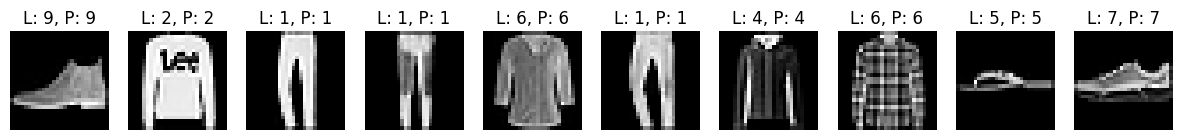

Test Accuracy,▁
Train accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
Train loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▄▅▆▇▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇▇█▇▇█▇█
Validation loss,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
Test Accuracy,93.64
Train accuracy,93.11455
Train loss,0.18878
Validation Accuracy,94.32
Validation loss,0.16609


In [7]:
# 모델 학습 및 평가 실행
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')  # 현재 시간 문자열 생성
    project_name = "cnn_mnist_test_code"  # 프로젝트 이름 설정
    wandb.init(
        mode="online",  # Wandb 온라인 모드
        project=project_name,  # 프로젝트 이름
        notes="mnist experiment with cnn",  # 프로젝트 노트
        tags=["cnn", "mnist"],  # 태그 추가
        name=run_time_str,  # 실행 시간 이름
        config=config  # 설정 전달
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 장치 설정

    # 모델 초기화
    model = CNN()

    # 모델 요약 출력
    model.to('cpu')  # CPU에서 모델 요약 확인
    print(summary(model, input_size=(64, 1, 28, 28)))  # 모델 구조 출력

    # 모델 장치 이동
    model.to(device)

    # 손실 함수 및 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()  # 손실 함수 설정
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)  # 옵티마이저 설정

    # 학습 및 평가 실행
    train_model(model, train_loader, validation_loader, criterion, optimizer, device, num_epochs=config.epochs)  # 학습
    test_model(model, test_loader, device)  # 테스트

    # 테스트 데이터 예측 및 시각화
    visualize_predictions(model, test_loader, device)  # 예측 시각화

    # Wandb 종료
    wandb.finish()

코딩을 통해 얻은 기술적 사항
---------------------------------------
다양한 하이퍼파라미터 튜닝의 중요성

학습률, 배치 크기, 드롭아웃 비율 등의 하이퍼파라미터 조정이 모델 성능에 미치는 영향을 체감했습니다. 특히, 작은 변화가 학습 시간과 정확도에 큰 영향을 미쳤습니다.

모델 복잡도와 성능의 상관관계
컨볼루션 층이나 채널 수를 무작정 늘리기보다 *적절한 모델 설계*가 중요하다는 점을 배웠습니다. 지나치게 복잡한 구조는 과적합을 유발하거나 학습 속도를 느리게 만들 수 있다는 점을 확인했습니다.

Early Stopping으로 불필요한 학습 시간을 줄이고 원하는 학습량을 얻고, Learning Rate Scheduler로 학습 후반부의 안정적인 성능 향상을 도모할 수 있었습니다.

코딩을 통해 얻은 고찰
----------------------------------
단순히 모델을 복잡하게 하는 것이 성능을 보장하지 않는다.
다양한 기능(데이터 증강, Batch Normalization, Dropout 등)을 추가했지만, 무조건적인 추가가 항상 긍정적인 결과로 이어지지 않는다는 점을 알게 되었습니다. 모델 성능은 데이터셋, 모델 구조, 하이퍼파라미터 간의 조화를 통해 결정됩니다.

모델 성능 개선 과정의 반복성
실험은 단 한 번의 시도로 끝나는 것이 아니라, 계속해서 시도하고 실패하며 얻는 경험의 연속임을 깨달았습니다. 특히, 실패한 시도를 기록하고 학습한 점을 다음 실험에 적용하는 것이 중요했습니다.

코드 디버깅 및 분석의 중요성
성능이 기대에 미치지 못할 때, 원인을 파악하기 위해 기록된 로그와 모델의 동작을 분석하는 과정이 필요했습니다. 이를 통해 성능 저하의 원인을 발견하고 개선할 수 있었습니다.

다다익선이 아닌 최적의 균형점 찾기
하이퍼파라미터, 모델 복잡도, 데이터 증강 등을 너무 많이 시도하면 오히려 학습 과정이 불안정해지거나 과적합이 발생했습니다. 적절한 균형점을 찾는 과정이 가장 어렵지만 중요하다는 점을 깨달았습니다.


숙제 후기

이번 과제는 역대급으로 어려웠습니다. 모델의 성능 향상을 위해 다양한 시도를 했지만, 
왜 성능이 향상되거나 감소하는지 명확하게 이해하기 어려웠습니다. 
컨볼루션 층을 추가하면 학습 시간이 길어지고 성능이 오히려 감소하는 경우도 있었고, 
최적의 성능을 얻기 위해 하이퍼파라미터를 조정하는 과정이 매우 힘들었습니다.

그래도 최대한 다양한 기능을 추가하고, 하이퍼파라미터를 조정해가며 
검증 정확도와 시험 정확도를 겨우 높일 수 있었습니다. 우선 코드를 전반적으로
확실하게 내 코드로 만들기 위해서 모든 줄을 이해하려고 노력하였습니다. 그러다 보니 모든 줄에
주석이 생기게 되었습니다. 정말 이 과제를 해결하는데 정말 오랜 시간이 들었지만 Validation과 test의 값이
94% 93%를 넘는 결과물을 보였을 때의 쾌감을 잊지 못할 거 같습니다. 또한
이번 과제를 통해 모델 성능 향상에는 단순히 기능 추가만으로는 
해결되지 않는 많은 고민이 필요하다는 점을 배우게 되었습니다. 마지막으로 학습하는데 시간이 너무 오래걸려 힘들었습니다...